In [36]:
import torch
import pytorch3d
import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes, load_obj
# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath('..//'))

from src.plot_image_grid import image_grid

In [8]:


# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "../assets"
obj_filename = os.path.join(DATA_DIR, "cow/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)



(-0.5, 1023.5, 1023.5, -0.5)

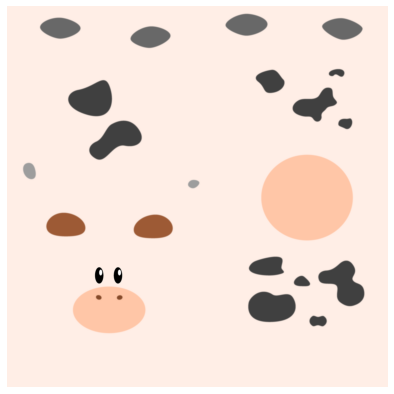

In [10]:
plt.figure(figsize=(7,7))
texture_image = mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

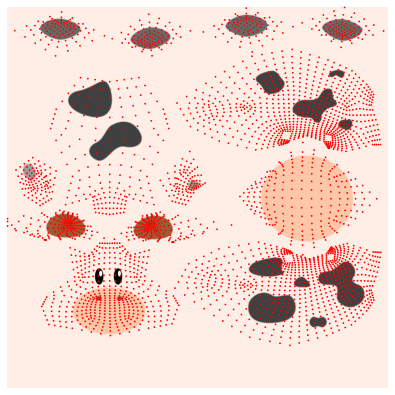

In [11]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off")

In [14]:
R, T = look_at_view_transform(2.7, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [16]:
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

(-0.5, 511.5, 511.5, -0.5)

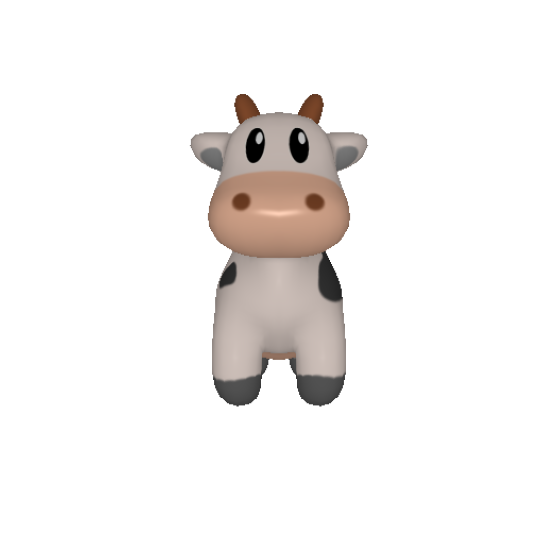

In [17]:
images = renderer(mesh)
plt.figure(figsize=(10,10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")

In [19]:
lights.location = torch.tensor([0.0, 0.0, 1.0], device=device)[None]
images_2 = renderer(mesh, lights=lights)

(-0.5, 511.5, 511.5, -0.5)

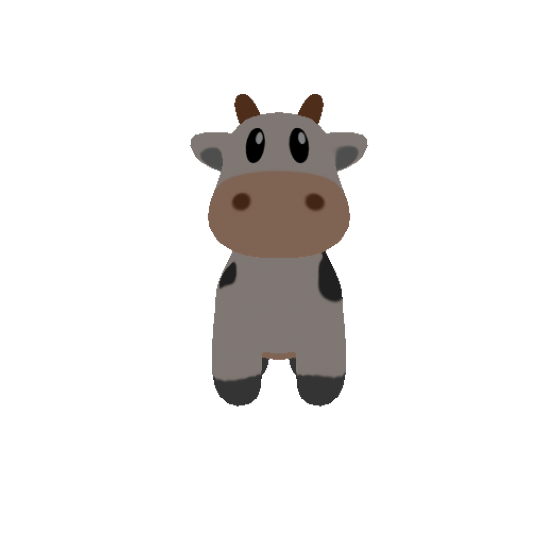

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(images_2[0, ..., :3].cpu().numpy())
plt.axis("off")

In [30]:
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras=FoVPerspectiveCameras(device=device, R=R, T=T)
lights.location = torch.tensor([[2, 2, -2]], device=device)

materials = Materials(
    device=device,
    specular_color=[[0, 0, 3]],
    shininess=1.0
)

images_3 = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

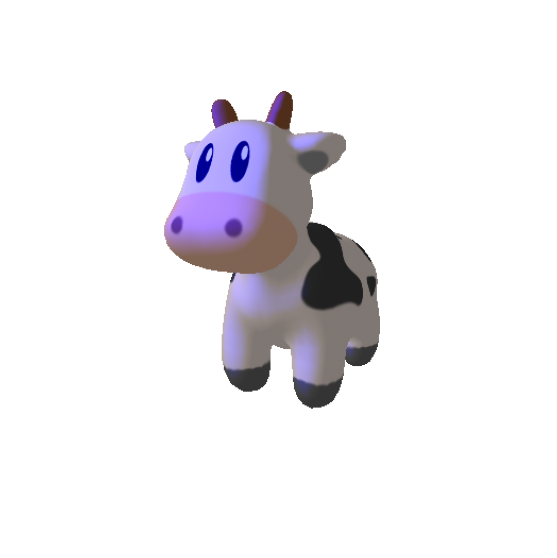

In [31]:

plt.figure(figsize=(10, 10))
plt.imshow(images_3[0, ..., :3].cpu().numpy())
plt.axis("off")

In [32]:
batch_size = 20

meshes = mesh.extend(batch_size)

elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

lights.location = torch.tensor([[0,0,-3]], device=device)

In [33]:
images_4 = renderer(meshes, cameras=cameras, lights=lights)

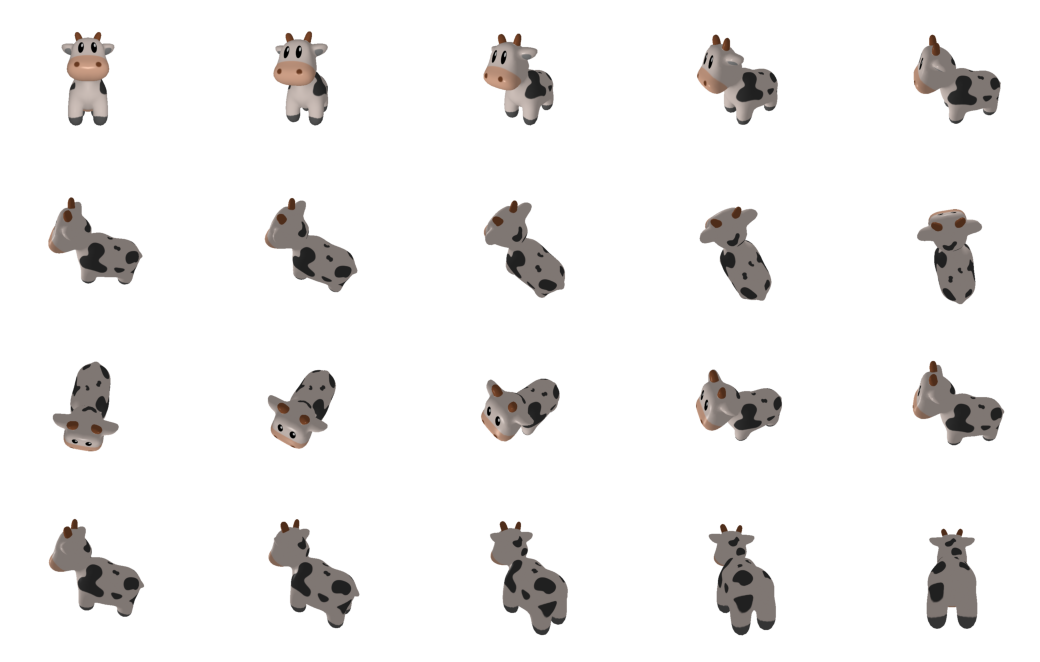

In [38]:
image_grid(images_4.cpu().numpy(), rows=4, cols=5, rgb=True)

In [37]:
verts, faces_idx, _ = load_obj(obj_filename)
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()